Keras Doc: [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

**Keras Documentation에서 이상한 점**
1. Augmentation이 Test set에도 적용
2. CLS token 없음
3. transformer의 FeedForward와 MLP header를 동인한 파라미터로 사용

**이번 예제에서 배운 점**
1. [einops](https://github.com/arogozhnikov/einops)나 einsum이 굉장히 많이 활용되고 있음
2. google도 이젠 tensorflow 말고 [flax](https://github.com/google/flax) 사용 많이 하는 듯 
3. pytorch의 chunk function
4. activation function으로 ReLU에에 GELU로 대체되고 있다

# ViT (Vision Transform)

- Paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf)


![](https://github.com/lucidrains/vit-pytorch/raw/main/images/vit.gif)

![image](https://user-images.githubusercontent.com/37654013/124294454-ad0dc100-db92-11eb-8056-08f3c9f9cd21.png)

![image](https://user-images.githubusercontent.com/37654013/124294795-1097ee80-db93-11eb-9656-faff0ebb4272.png)

In [22]:
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from einops.layers.torch import Rearrange
from einops import rearrange, repeat

from torch import einsum

from pytorch_pretrained_vit import ViT

import json

In [2]:
class Config:
    datadir            = '../data'
    image_size         = 384
    patch_size         = 16
    seed               = 223
    epochs             = 30
    batch_size         = 8
    accumulation_steps = 64
    lr                 = 0.001
    num_classes        = 100
    num_workers        = 8
    gpu_num            = 1

In [3]:
config = Config()

In [4]:
device = f'cuda:{config.gpu_num}' if torch.cuda.is_available() else 'cpu'

# Load CIFAR100

In [5]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((config.image_size,)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(degrees=0.02),
    torchvision.transforms.RandomResizedCrop(size=(config.image_size,), scale=(0.8,1), ratio=(1,1.)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((config.image_size,)),
])

In [6]:
trainset = torchvision.datasets.CIFAR100(root=config.datadir, 
                                         train=True, 
                                         download=True,
                                         transform=transform_train)
testset = torchvision.datasets.CIFAR100(root=config.datadir, 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=config.batch_size, 
                                          shuffle=True, 
                                          num_workers=config.num_workers)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=config.batch_size, 
                                         shuffle=True, 
                                         num_workers=config.num_workers)

Files already downloaded and verified
Files already downloaded and verified


# Build Model

- ViT Source Code: https://github.com/lucidrains/vit-pytorch/blob/64a2ef6462bde61db4dd8f0887ee71192b273692/vit_pytorch/vit.py#L10

![image](https://user-images.githubusercontent.com/37654013/124264038-f815dd00-db6e-11eb-8042-a120e820a823.png)

In [7]:
class PositionalEmbedding1D(nn.Module):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, seq_len, dim):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len, dim))
    
    def forward(self, x):
        """Input has shape `(batch_size, seq_len, emb_dim)`"""
        return x + self.pos_embedding

In [15]:
model_name = 'B_16_imagenet1k'
model = ViT(model_name, 
            pretrained=True, 
            num_classes=config.num_classes).to(device)

Loaded pretrained weights.


In [16]:
num_params = np.sum([np.prod(p.size()) for p in model.parameters()])
print('Number of ViT parameters: ',num_params)

Number of ViT parameters:  86167396


# Train

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
def train(
    model, dataloader, criterion, optimizer, accumulation_steps, device='cpu'
):
    correct = 0 
    total = 0
    total_loss = 0
    
    optimizer.zero_grad()
    for idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # predict
        outputs = model(inputs)
            
        # loss and update
        loss = criterion(outputs, targets)
        (loss / accumulation_steps).backward()
        
        if (idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # total loss and acc
        total_loss += loss.item()
        
        preds = outputs.argmax(dim=1) 
        correct += targets.eq(preds).sum().item()
        total += targets.size(0)
        
        if idx == (len(dataloader)-1):
            print('[%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                  (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total),end='\n')
        else:
            print('[%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                  (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total),end='\r')
        
    return 100.*correct/total, total_loss/len(dataloader)
        
def test(model, dataloader, criterion, device='cpu'):
    correct = 0
    correct_top5 = 0
    total = 0
    total_loss = 0
    
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # predict
            outputs = model(inputs)
            
            # loss 
            loss = criterion(outputs, targets)
            
            # total loss and acc
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            _, preds_top5 = outputs.topk(5, dim=1)
            
            correct += targets.eq(preds).sum().item()
            correct_top5 += preds_top5.eq(targets.view(-1, 1).expand_as(preds_top5)).sum().item()
            total += targets.size(0)
                        
            if idx == (len(dataloader)-1):
                print('[%d/%d]: Loss: %.3f | Top-1 Acc: %.3f%% [%d/%d] | Top-5 Acc: %.3f%% [%d/%d]' % 
                      (idx+1, len(dataloader), total_loss/(idx+1), 
                       100.*correct/total, correct, total,
                       100.*correct_top5/total, correct_top5, total),end='\n')
            else:
                print('[%d/%d]: Loss: %.3f | Top-1 Acc: %.3f%% [%d/%d] | Top-5 Acc: %.3f%% [%d/%d]' % 
                      (idx+1, len(dataloader), total_loss/(idx+1), 
                       100.*correct/total, correct, total,
                       100.*correct_top5/total, correct_top5, total),end='\r')
                
        return 100.*correct/total, 100.*correct_top5/total, total_loss/len(dataloader)
            

In [ ]:
# history
history = {
    'train':{
        'top1-acc':[],
        'loss':[]
    },
    'test':{
        'top1-acc':[],
        'top5-acc':[],
        'loss':[]
    }
}

for epoch in range(config.epochs):
    print(f'Epoch: {epoch+1}/{config.epochs}')
    train_top1acc, train_loss = train(model, trainloader, criterion, optimizer, config.accumulation_steps, device=device)
    test_top1acc, test_top5acc, test_loss = test(model, testloader, criterion, device)
    
    # history
    history['train']['top1-acc'].append(train_top1acc)
    history['train']['loss'].append(train_loss)
    history['test']['top1-acc'].append(test_top1acc)
    history['test']['top5-acc'].append(test_top5acc)
    history['test']['loss'].append(test_loss)

Epoch: 1/30
[6250/6250]: Loss: 4.545 | Acc: 52.944% [26472/50000]
[1250/1250]: Loss: 4.483 | Top-1 Acc: 60.070% [6007/10000] | Top-5 Acc: 84.680% [8468/10000]
Epoch: 2/30
[6250/6250]: Loss: 4.420 | Acc: 60.972% [30486/50000]
[1250/1250]: Loss: 4.353 | Top-1 Acc: 62.450% [6245/10000] | Top-5 Acc: 86.580% [8658/10000]
Epoch: 3/30
[6250/6250]: Loss: 4.281 | Acc: 64.030% [32015/50000]
[1250/1250]: Loss: 4.208 | Top-1 Acc: 65.290% [6529/10000] | Top-5 Acc: 88.450% [8845/10000]
Epoch: 4/30
[6250/6250]: Loss: 4.127 | Acc: 67.078% [33539/50000]
[1250/1250]: Loss: 4.049 | Top-1 Acc: 68.170% [6817/10000] | Top-5 Acc: 90.500% [9050/10000]
Epoch: 5/30
[6250/6250]: Loss: 3.959 | Acc: 70.016% [35008/50000]
[1250/1250]: Loss: 3.876 | Top-1 Acc: 71.380% [7138/10000] | Top-5 Acc: 92.160% [9216/10000]
Epoch: 6/30
[6250/6250]: Loss: 3.783 | Acc: 72.644% [36322/50000]
[1250/1250]: Loss: 3.698 | Top-1 Acc: 73.170% [7317/10000] | Top-5 Acc: 93.280% [9328/10000]
Epoch: 7/30
[6250/6250]: Loss: 3.602 | Acc: 74

In [ ]:
# save model
weights = {'model':model.state_dict()}
torch.save(weights, 'ViT_CIFAR100_fine_tune_B_16_imagenet1k.pt')

In [23]:
json.dump(history, open('ViT_CIFAR100_fine_tune_B_16_imagenet1k.json','w'), indent=4)

# History

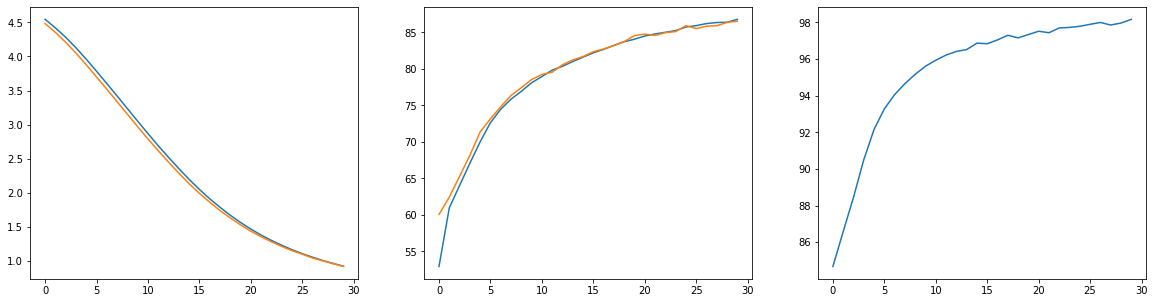

In [25]:
f, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].plot(np.arange(len(history['train']['loss'])), history['train']['loss'])
ax[0].plot(np.arange(len(history['test']['loss'])), history['test']['loss'])
ax[1].plot(np.arange(len(history['train']['top1-acc'])), history['train']['top1-acc'])
ax[1].plot(np.arange(len(history['test']['top1-acc'])), history['test']['top1-acc'])
ax[2].plot(np.arange(len(history['test']['top5-acc'])), history['test']['top5-acc'])

# Visualize Position Embedding

![image](https://user-images.githubusercontent.com/37654013/124371571-fc044500-dcbd-11eb-9da0-3e2f26540e08.png)


In [56]:
def cos_sim(a, b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

pos_embed = model.positional_embedding.pos_embedding[:,1:,:].squeeze().cpu().detach().numpy()

pos_sim = np.zeros((pos_embed.shape[0], pos_embed.shape[0]))

for i in range(pos_embed.shape[0]):
    for j in range(pos_embed.shape[0]):
        pos_sim[i,j] = cos_sim(pos_embed[i], pos_embed[j])

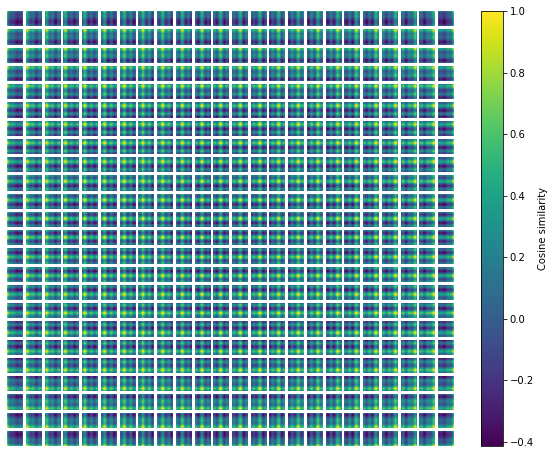

In [60]:
num_row, num_col = [config.image_size // config.patch_size] * 2
f, axes = plt.subplots(num_row, num_col, figsize=(10,8))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(pos_sim[i].reshape(num_row, num_col))
    ax.axis('off')

cbar = plt.colorbar(im, ax=axes.ravel().tolist())
cbar.set_label('Cosine similarity')